In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import scipy as sp
from collections import Counter
import json
import time
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
from torchvision import transforms
import albumentations
from albumentations import torch as AT
import os

# To have reproducible results and compare them
nr_seed = 2019
import numpy as np 
np.random.seed(nr_seed)

In [2]:
def crop_image1(img,tol=7):
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        
        return img


In [3]:
train = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
train_old = pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels.csv")
test = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

## check image attribute

In [4]:
def apply_img_attr(x,datatype='train_new'):
    lst = []
    if datatype=='train_new':
        im = cv2.imread(f"../input/aptos2019-blindness-detection/train_images/{x}.png")
    elif datatype=='test_new':
        im = cv2.imread(f"../input/aptos2019-blindness-detection/test_images/{x}.png")
    else :
        im = cv2.imread(f"../input/diabetic-retinopathy-resized/resized_train/{x}.jpeg")
        
    lst += im.shape[:2]
    im = crop_image_from_gray(im)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    lst += im.shape[:2]
    s1 = im.size
    mask = im > 7
    s2 = mask.sum()
    ratio = s2/s1
    lst.append(ratio)
    return lst

In [5]:
new_train = pd.concat([train,train['id_code'].apply(lambda x: pd.Series(apply_img_attr(x,datatype='train_new')))\
                    .rename(columns={0:"x",1:"y",2:"cropped_x",3:"cropped_y",4:"ratio"})],axis=1,join ='inner')
new_train.to_csv('../data/train_img-attr.csv')
new_train.head()

,id_code,diagnosis,x,y,cropped_x,cropped_y,ratio
0,000c1434d8d7,2,2136.0,3216.0,2136.0,2709.0,0.885965
1,001639a390f0,4,2136.0,3216.0,2136.0,2713.0,0.885399
2,0024cdab0c1e,1,1736.0,2416.0,1736.0,2259.0,0.891311
3,002c21358ce6,0,1050.0,1050.0,1050.0,1050.0,0.791934
4,005b95c28852,0,1536.0,2048.0,1378.0,1376.0,0.786894


In [6]:
new_test = pd.concat([test,test['id_code'].apply(lambda x: pd.Series(apply_img_attr(x,datatype='test_new')))\
                    .rename(columns={0:"x",1:"y",2:"cropped_x",3:"cropped_y",4:"ratio"})],axis=1,join ='inner')
new_test.to_csv('../data/test_img-attr.csv')
new_test.head()

,id_code,x,y,cropped_x,cropped_y,ratio
0,0005cfc8afb6,480.0,640.0,480.0,640.0,0.989251
1,003f0afdcd15,480.0,640.0,480.0,640.0,0.989401
2,006efc72b638,480.0,640.0,480.0,640.0,0.989681
3,00836aaacf06,480.0,640.0,480.0,640.0,0.989460
4,009245722fa4,480.0,640.0,480.0,640.0,0.989551


In [7]:
new_train_old = pd.concat([train_old,train_old['image'].apply(lambda x: pd.Series(apply_img_attr(x,datatype='train_old')))\
                    .rename(columns={0:"x",1:"y",2:"cropped_x",3:"cropped_y",4:"ratio"})],axis=1,join ='inner')
new_train_old.to_csv('../data/train_old_img-attr.csv')
new_train_old.head()

,image,level,x,y,cropped_x,cropped_y,ratio
0,10_left,0,683.0,1024.0,647.0,650.0,0.785448
1,10_right,0,683.0,1024.0,647.0,648.0,0.786073
2,13_left,0,768.0,1024.0,768.0,802.0,0.812109
3,13_right,0,768.0,1024.0,768.0,802.0,0.812183
4,15_left,1,679.0,1024.0,665.0,667.0,0.782548


In [ ]:
new_train = pd.read_csv('../data/train_img-attr.csv')
new_test = pd.read_csv('../data/test_img-attr.csv')
new_train_old = pd.read_csv('../data/train_old_img-attr.csv')

### train

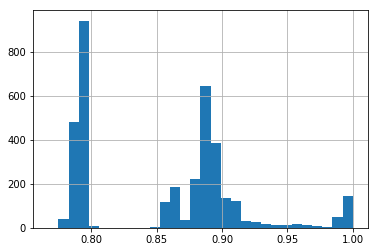

In [11]:
new_train['ratio'].hist(bins=30)

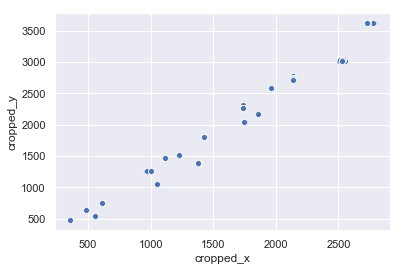

In [24]:
ax = sns.scatterplot(x="cropped_x", y="cropped_y", data=new_train)

### test

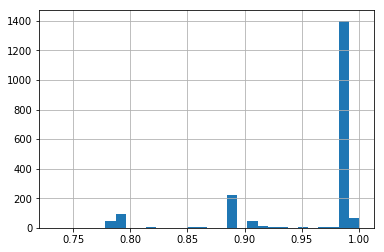

In [20]:
new_test['ratio'].hist(bins=30)

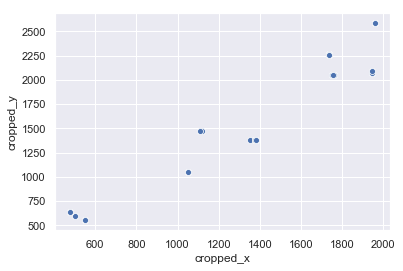

In [26]:
ax = sns.scatterplot(x="cropped_x", y="cropped_y", data=new_test)

### 2015

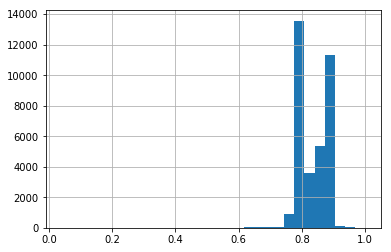

In [10]:
new_train_old['ratio'].hist(bins=30)

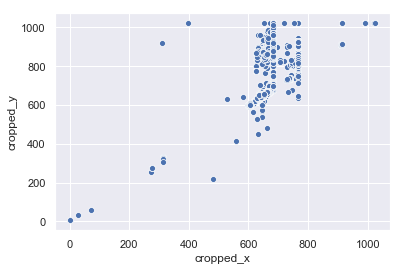

In [27]:
ax = sns.scatterplot(x="cropped_x", y="cropped_y", data=new_train_old)

In [28]:
new_train_old.describe()

,level,x,y,cropped_x,cropped_y,ratio
count,35126.000000,35126.000000,35126.000000,35126.000000,35126.000000,35126.000000
mean,0.526049,702.352929,1023.628822,686.663383,782.441212,0.831286
std,0.970390,39.767900,15.178057,51.103595,115.262956,0.047694
min,0.000000,289.000000,400.000000,3.000000,5.000000,0.038387
25%,0.000000,683.000000,1024.000000,651.000000,653.000000,0.785555
50%,0.000000,683.000000,1024.000000,683.000000,831.000000,0.826389
75%,1.000000,683.000000,1024.000000,683.000000,878.000000,0.876936
max,4.000000,1024.000000,1024.000000,1024.000000,1024.000000,0.999995


In [21]:
new_train_old[new_train_old['ratio']<0.5].head()

,image,level,x,y,cropped_x,cropped_y,ratio
632,766_left,1,768.0,1024.0,557.0,414.0,0.123965
1578,1986_left,0,768.0,1024.0,3.0,5.0,0.333333
2313,2857_right,0,768.0,1024.0,768.0,824.0,0.384521
3090,3829_left,2,315.0,400.0,273.0,255.0,0.361517
7604,9590_left,2,768.0,1024.0,747.0,676.0,0.214564


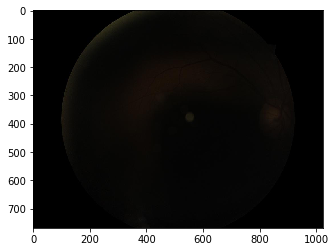

In [22]:
x = '2857_right'
im =Image.open(f'../input/diabetic-retinopathy-resized/resized_train/{x}.jpeg')
plt.imshow(im)

2015のデータの分布は特徴的
* 横長の画像が多い
* 光量が足りずに背景と同化している画像もある